In [16]:
#Instructions:
#1) Name the raw .fastq file: 'Aleks.fastq', UNZIPPED
#2) Input the following parameters - defaults are already set
#3) On the bar at the top, press 'Runtime' and then 'Restart and Run All'

#Take the reverse complement? Enter 'yes' or 'no'
rc = 'no'

#Desired Region to analyze (e.g. if 8nt constant region in 56nt sequence, input 'start, stop = 8, 48')
start, stop = 13, 23

#Quality Cutoff - what fraction of positions should have <1% error probability?
quality_cutoff = 0.9

#Number of Clusters (I WOULD MAKE THIS >50)
k = 50

In [17]:
#@title IMPORTS
import numpy as np
import matplotlib.pyplot as plt
!pip install Bio
from Bio import SeqIO
from Bio.Seq import Seq
from collections import Counter 
from Bio.Cluster import kcluster
import statistics
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import difflib
import seaborn as sns; sns.set_theme()
from collections import defaultdict
import collections

#!pip install ipython-autotime

In [18]:
#@title STATISTICS (note: this takes a few mins per round)

round = open('/Users/zoeweiss/Desktop/Desktop/fastq/smaller_ai/Aleks4.fastq').readlines()
quality = round[3::4]
seqs = round[1::4]
print('Number of raw seqs: '+str(len(seqs))) 

#Remove duplicates:
unique_seqs = []
unique_qualities = []
indicies_of_unique_seqs = list(np.unique(seqs, return_index=True)[1])
for index in sorted(np.unique(seqs, return_index = True)[1])[:-1]:
  unique_qualities.append(quality[index])
  unique_seqs.append(seqs[index])
print('Number of unique seqs: '+str(len(unique_seqs))) 

#Counts of all seqs
seq_dict = Counter(seqs)
seq_dict_list = [(k, v) for k, v in seq_dict.items()]
sorted_seq_dict = sorted(seq_dict_list, key = lambda x: x[1], reverse=True)
sorted_seq_dict_inve = sorted(seq_dict_list, key = lambda x: x[1])

#Take RC if desired
pre_trim = []
if rc == 'yes':
  rc_seqs = []
  for sequence in unique_seqs:
      rc_seqs.append(str(Seq(sequence).reverse_complement()).strip('\n'))
  pre_trim = rc_seqs
else:
  for sequence in unique_seqs:
      pre_trim.append(str(Seq(sequence)).strip('\n'))
if rc == 'yes':
  print('Number of seqs after rc: '+str(len(pre_trim))) 

#Trim
trimmed = []
for seq in pre_trim:
  trimmed.append(seq[(start-1):(stop-1)])
print('Number of seqs after trimming: '+str(len(trimmed))) 

#Filter by quality
high_quality = []
acceptable_quals_1_percent_error = [5,6,7,8,9,':',';', '<', '=', '>', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K']
for seq in range(len(unique_qualities)):
  overlap=0
  for char in list(set(unique_qualities[seq]).intersection(acceptable_quals_1_percent_error)):
        overlap+=unique_qualities[seq].count(char)
  if overlap/len(unique_qualities[1])>quality_cutoff:
        high_quality.append(trimmed[seq].strip("\n"))
print('Number of high quality seqs: '+str(len(high_quality))) 

Number of raw seqs: 2519
Number of unique seqs: 1615
Number of seqs after trimming: 1615
Number of high quality seqs: 592


In [19]:
#@title MOST ABUNDANT SEQUENCES [NOT FILTERED BY QUALITY]
#10 Top Sequences in the last round
print('10 Most Abundant Sequences, Counts')
for seq in sorted_seq_dict[:10]:
  print(seq[0].strip("\n"), seq[1])


10 Most Abundant Sequences, Counts
ACTCACTGACACAGATCCACTCACGGACAGCGGAATGCTGCCAACCGTGCGGGCTAATTGGCAGACTGAGCTCGCTGTCCT 252
ACTCACTGACACAGATCCACTCACGGACAGCGCCTAGCTAGCGCTGACTAGGACAGATGAGCGGCGGAACCACGCTGTCCT 98
ACTCACTGACACAGATCCACTCACGGACAGCGGAACCCTTATCACAGTCGTGCGGATTTGTAAGCCTAAGCGCGCTGTCCT 44
ACTCACTGACACAGATCCACTCACGGACAGCGTTAGTGAAATTGGTGCCCAAGCAGAGAATTGGGATAAATCCGCTGTCCT 43
ACTCACTGACACAGATCCACTCACGGAGCGTATTGGGTGCCGATTTCCTCTAATTTTAAAGTGCGGATAACGCTGTCCTTT 36
ACTCACTGACACAGATCCACTCACGGACAGCGGAATGCTACCAACCGTGCGGGCTAATTGGCAGACTGAGCTCGCTGTCCT 21
ACTCACTGACACAGATCCACTCACGGACAGCGAGAGACCGTGAGCTTGCGGAATGTTAGCAGAACAGAACTGCGCTGTCCT 19
ACTCACTGACACAGATCCACTCACGGACGCGCCAGAAGATCAATTTAGTGCGATTGCTAAAGACGTAAACCCGCTGTCCTT 18
ACTCACTGACACAGATCCACTCACGGACAGCGGAATGCTGCCAACCGTGCGGGCTAATTGGCAGACTGAGCTCGCTGCCCT 18
ACTCACTGACACAGATCCACTCACGGACAGCGAGCCACTGCGGAAGACCTTAAGAGGTGTAATTGCTCACCCCGCTGTCCT 18


In [20]:
#@title FUNCTION TO FIND CONSERVED POSITIONS
#Idtenify conserved positions in cluster 1

def make_heatmap(seqs_to_analyze):
  heatmap_data = []

  for position in range(len(seqs_to_analyze[0])):
      options = []
      for seq in seqs_to_analyze:
          options.append(seq[position])
      raw_options = [(k, v) for k, v in Counter(options).items()]
      nuc_list = []
      for element in raw_options:
          nuc_list.append(element[0])
      if 'A' not in nuc_list:
            raw_options.append(('A', 0))
      if 'C' not in nuc_list:
            raw_options.append(('C', 0))
      if 'G' not in nuc_list:
            raw_options.append(('G', 0))
      if 'T' not in nuc_list:
            raw_options.append(('T', 0))    
      raw_options = sorted(raw_options, key=lambda x: x[0])        
      
      heatmap_data_position = []
      for element in raw_options:
          heatmap_data_position.append(element[1]/len(seqs_to_analyze))
      heatmap_data.append(heatmap_data_position)


  fig, ax = plt.subplots(figsize = (30,6));
  im = ax.imshow(np.array(heatmap_data).transpose(), interpolation='nearest', cmap='YlOrRd');
  im.set_clim(0,1)
  cbar = fig.colorbar(im, orientation='vertical',)
  y_label_list = ['', 'A', 'C', 'G', 'T', ''];
  ax.set_yticks(range(-1, 1+len(heatmap_data[0])));
  ax.set_yticklabels(y_label_list);
  ax.set_xticks(range(len(heatmap_data)));
  ax.set_xticklabels(range(1, len(heatmap_data)+1));
  ax.grid(False)
  plt.show()
  return heatmap_data

Sequences used to generate heatmap: 592


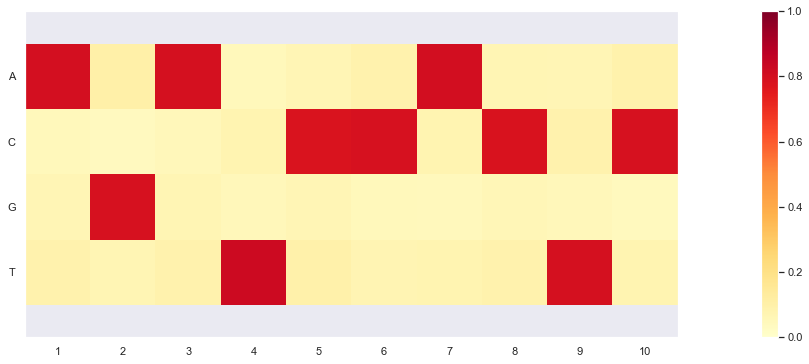

[[0.7972972972972973,
  0.048986486486486486,
  0.06587837837837837,
  0.08783783783783784],
 [0.10304054054054054,
  0.03885135135135135,
  0.7905405405405406,
  0.06756756756756757],
 [0.793918918918919,
  0.052364864864864864,
  0.06756756756756757,
  0.08614864864864864],
 [0.048986486486486486,
  0.07601351351351351,
  0.052364864864864864,
  0.8226351351351351],
 [0.0625, 0.7787162162162162, 0.06418918918918919, 0.0945945945945946],
 [0.08614864864864864,
  0.7922297297297297,
  0.05067567567567568,
  0.07094594594594594],
 [0.8023648648648649,
  0.0777027027027027,
  0.04391891891891892,
  0.07601351351351351],
 [0.06756756756756757,
  0.7837837837837838,
  0.060810810810810814,
  0.08783783783783784],
 [0.06587837837837837,
  0.08783783783783784,
  0.052364864864864864,
  0.793918918918919],
 [0.0929054054054054,
  0.7922297297297297,
  0.04054054054054054,
  0.07432432432432433]]

In [8]:
#@title REDO HEATMAP FOR A KNOWN MOTIF [FILTERED BY QUALITY]

#Position motif starts at
motif_start = 1
#Motif define
motif = ''

motif_subset = []
for seq in high_quality:
  if seq[motif_start-1:(motif_start-1)+len(motif)] == motif:
    motif_subset.append(seq)

print('Sequences used to generate heatmap: '+str(len(motif_subset)))
make_heatmap(motif_subset)


In [21]:
#@title CLUSTER SEQUENCES (may take up to 5 mins) [FILTERED BY QUALITY]
#SEE CLUSTERING CSV FILE ON LEFT PANEL (Aleks_Clusters.csv) AND OPEN IN EXCEL

matrix = np.asarray([np.fromstring(str(s), dtype=np.uint8) for s in high_quality]);
kmeans = KMeans(init="random", n_clusters=k,n_init=10,max_iter=300,random_state=42)
kmeans.fit(matrix)
labels = kmeans.labels_[:]

all_clusters = []
for cluster_num in range(0, k):
  seqs_in_cluster = []
  for seq in range(len(labels)):
    if labels[seq] == cluster_num:
      seqs_in_cluster.append(high_quality[seq])
  all_clusters.append(seqs_in_cluster)

<ipython-input-21-40b3f5931213>:4: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  matrix = np.asarray([np.fromstring(str(s), dtype=np.uint8) for s in high_quality]);


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Top Cluster 1
Number of Seqs in Cluster: 433


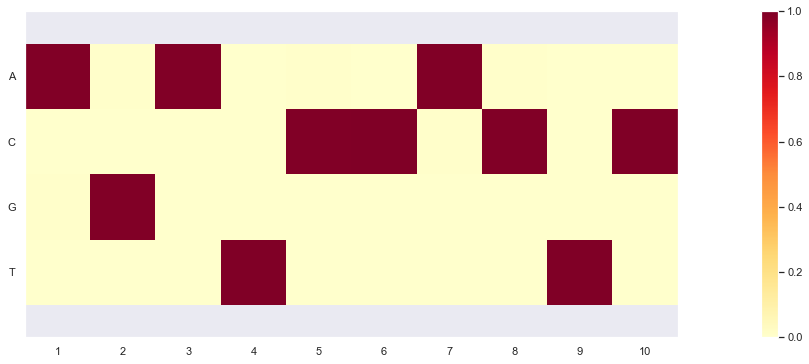

In [22]:
#@title REDO HEATMAP FOR THE CLUSTERS CONTAINING THE TOP 10 SEQS (may have overlap or one of the top seqs may be low quality, so <10 plots may appear) [FILTERED BY QUALITY]
top_10 = sorted_seq_dict[:10]
top_clusters = []

for top in top_10:
  for cluster in range(len(all_clusters)):
    for cluster_seq in all_clusters[cluster]:
      if rc == 'no':
        if cluster_seq == top[0][(start-1):(stop-1)]:
          top_clusters.append(cluster)
          break
      
      if rc == 'yes':
        if cluster_seq == Seq(top_10[0][0][(start-1):(stop-1)]).reverse_complement():
          top_clusters.append(cluster)
          break

print(top_clusters)
top_clusters = list(set(top_clusters))

counter = 0
for top_clust in top_clusters:
  counter+=1
  print('Top Cluster '+str(counter))
  print('Number of Seqs in Cluster: '+str(len(all_clusters[top_clust])))
  make_heatmap(all_clusters[top_clust])

In [23]:
#@title FUNCTION TO MAKE HEATMAP FOR TOP/BOTTOM SEQUENCES, WITH/WITHOUT REPEATS [FILTERED BY QUALITY]
def heatmap_top_bottom_N(N, order, weighted):
  if weighted == False:
    top= []
    seq = 0
    if order == 'top':

      while len(top)<N:
        if sorted_seq_dict[seq][0][(start-1):(stop-1)] in high_quality:
          if sorted_seq_dict[seq][0][(start-1):(stop-1)] not in top:
            top.append(sorted_seq_dict[seq][0][(start-1):(stop-1)])
        seq+=1
      print('Heatmap made with '+str(len(top))+' seqs')
      return make_heatmap(top)

    else:
      if order == 'bottom':

        while len(top)<N:
          if sorted_seq_dict_inve[seq][0][(start-1):(stop-1)] in high_quality:
            if sorted_seq_dict_inve[seq][0][(start-1):(stop-1)] not in top:
              top.append(sorted_seq_dict_inve[seq][0][(start-1):(stop-1)])
          seq+=1
        print('Heatmap made with '+str(len(top))+' seqs')
        return make_heatmap(top)

      else:
        print('please enter either (top) or (bottom) for order')
  
  if weighted == True:
    top= []
    seq = 0
    if order == 'top':

      while len(top)<N:
        if sorted_seq_dict[seq][0][(start-1):(stop-1)] in high_quality:
          if sorted_seq_dict[seq][0][(start-1):(stop-1)] not in top:
            top.append(sorted_seq_dict[seq][0][(start-1):(stop-1)])
        seq+=1
      
      replicates = []
      for top_seq in top:
        for seq in sorted_seq_dict:
          if top_seq in seq[0]:
            replicates.append(seq[1])
            break

      weighted_seqs = []
      for i in range(len(top)):
        weighted_seqs+=[top[i]]*replicates[i]

      print('Heatmap made with '+str(len(weighted_seqs))+' seqs')
      return make_heatmap(weighted_seqs)

    else:
      if order == 'bottom':

        while len(top)<N:
          if sorted_seq_dict_inve[seq][0][(start-1):(stop-1)] in high_quality:
            if sorted_seq_dict_inve[seq][0][(start-1):(stop-1)] not in top:
              top.append(sorted_seq_dict_inve[seq][0][(start-1):(stop-1)])
          seq+=1
        
        replicates = []
        for top_seq in top:
          for seq in sorted_seq_dict_inve:
            if top_seq in seq[0]:
              replicates.append(seq[1])
              break

        weighted_seqs = []
        for i in range(len(top)):
          weighted_seqs+=[top[i]]*replicates[i]

        print('Heatmap made with '+str(len(weighted_seqs))+' seqs')
        return make_heatmap(weighted_seqs)

      else:
        print('please enter either (top) or (bottom) for order')
  

Heatmap made with 50 seqs


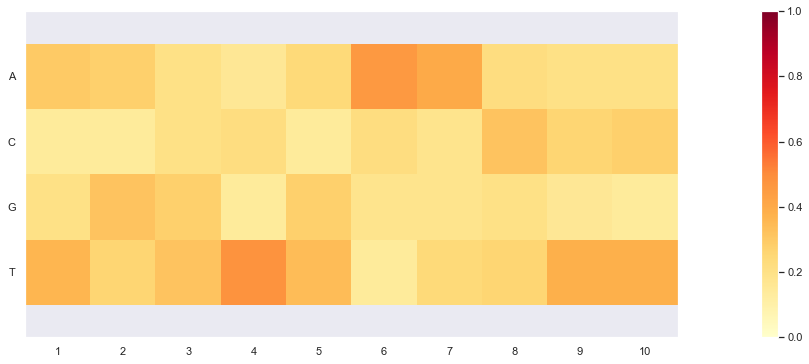

[[0.3, 0.14, 0.2, 0.36],
 [0.28, 0.14, 0.32, 0.26],
 [0.2, 0.2, 0.28, 0.32],
 [0.16, 0.22, 0.14, 0.48],
 [0.24, 0.14, 0.28, 0.34],
 [0.46, 0.22, 0.18, 0.14],
 [0.4, 0.18, 0.18, 0.24],
 [0.22, 0.32, 0.2, 0.26],
 [0.2, 0.26, 0.16, 0.38],
 [0.2, 0.28, 0.14, 0.38]]

In [13]:
#@title HEATMAP FOR TOP 50 SEQUENCES, WITHOUT REPEATS [FILTERED BY QUALITY]
heatmap_top_bottom_N(N = 50, order = 'top', weighted = False)

Heatmap made with 10 seqs


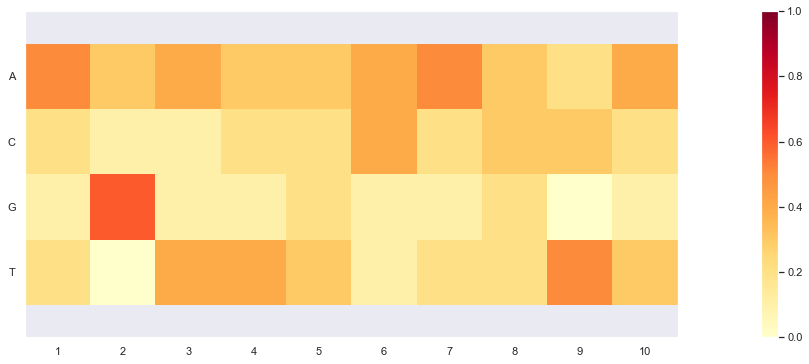

[[0.5, 0.2, 0.1, 0.2],
 [0.3, 0.1, 0.6, 0.0],
 [0.4, 0.1, 0.1, 0.4],
 [0.3, 0.2, 0.1, 0.4],
 [0.3, 0.2, 0.2, 0.3],
 [0.4, 0.4, 0.1, 0.1],
 [0.5, 0.2, 0.1, 0.2],
 [0.3, 0.3, 0.2, 0.2],
 [0.2, 0.3, 0.0, 0.5],
 [0.4, 0.2, 0.1, 0.3]]

In [25]:
#@title HEATMAP FOR TOP 10 SEQUENCES, WITHOUT REPEATS [FILTERED BY QUALITY]
heatmap_top_bottom_N(N = 10, order = 'top', weighted = False)

Heatmap made with 10 seqs


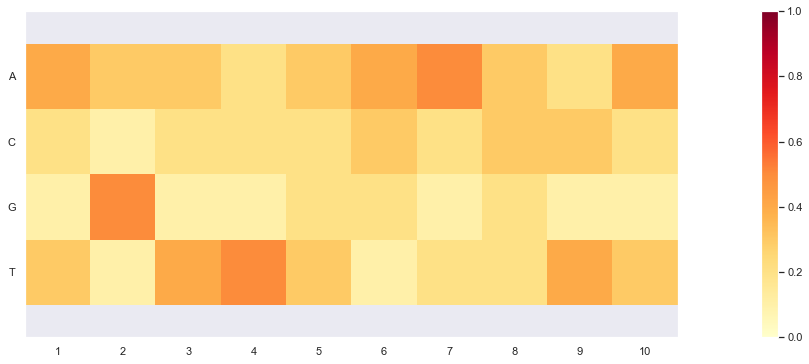

[[0.4, 0.2, 0.1, 0.3],
 [0.3, 0.1, 0.5, 0.1],
 [0.3, 0.2, 0.1, 0.4],
 [0.2, 0.2, 0.1, 0.5],
 [0.3, 0.2, 0.2, 0.3],
 [0.4, 0.3, 0.2, 0.1],
 [0.5, 0.2, 0.1, 0.2],
 [0.3, 0.3, 0.2, 0.2],
 [0.2, 0.3, 0.1, 0.4],
 [0.4, 0.2, 0.1, 0.3]]

In [26]:
#@title HEATMAP FOR BOTTOM 10 SEQUENCES, WITHOUT REPEATS [FILTERED BY QUALITY]
heatmap_top_bottom_N(N = 10, order = 'bottom', weighted = False)